# Predicting Student Admissions with Neural Networks
In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/

## Loading the data
To load the data and format it nicely, we will use two very useful packages called Pandas and Numpy. You can read on the documentation here:
- https://pandas.pydata.org/pandas-docs/stable/
- https://docs.scipy.org/

In [2]:
# Importing pandas and numpy
import pandas as pd
import numpy as np

# Reading the csv file into a pandas DataFrame
data = pd.read_csv('student_data.csv')

# Printing out the first 10 rows of our data
data[:10]

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
5,1,760,3.00,2
6,1,560,2.98,1
7,0,400,3.08,2
8,1,540,3.39,3
9,0,700,3.92,2


## Plotting the data

First let's make a plot of our data to see how it looks. In order to have a 2D plot, let's ingore the rank.

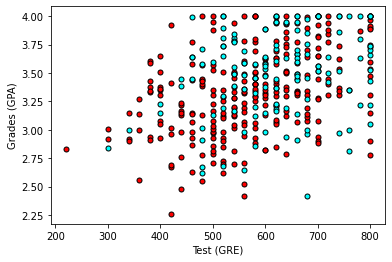

In [3]:
# Importing matplotlib
import matplotlib.pyplot as plt

# Function to help us plot
def plot_points(data):
    X = np.array(data[["gre","gpa"]])
    y = np.array(data["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    
# Plotting the points
plot_points(data)
plt.show()

Roughly, it looks like the students with high scores in the grades and test passed, while the ones with low scores didn't, but the data is not as nicely separable as we hoped it would. Maybe it would help to take the rank into account? Let's make 4 plots, each one for each rank.

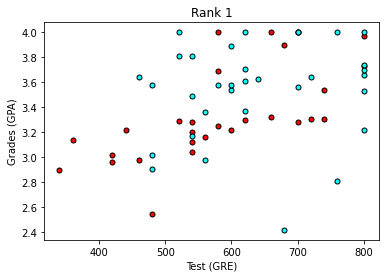

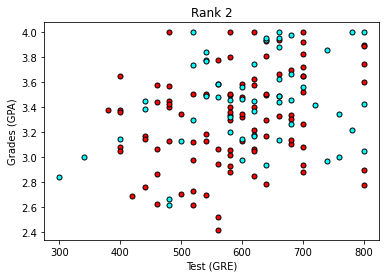

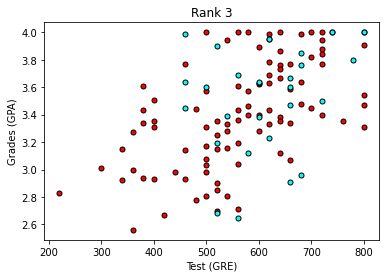

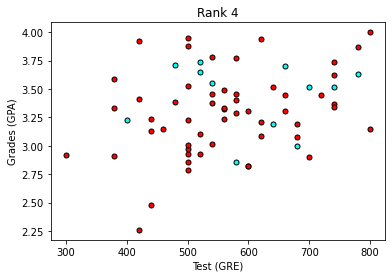

In [4]:
# Separating the ranks
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]

# Plotting the graphs
plot_points(data_rank1)
plt.title("Rank 1")
plt.show()
plot_points(data_rank2)
plt.title("Rank 2")
plt.show()
plot_points(data_rank3)
plt.title("Rank 3")
plt.show()
plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

This looks more promising, as it seems that the lower the rank, the higher the acceptance rate. Let's use the rank as one of our inputs. In order to do this, we should one-hot encode it.

## TODO: One-hot encoding the rank
Use the `get_dummies` function in Pandas in order to one-hot encode the data.

In [5]:
# TODO:  Make dummy variables for rank
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1, sort=False)

# TODO: Drop the previous rank column
one_hot_data.drop('rank', axis=1, inplace=True)

# Print the first 10 rows of our data
one_hot_data[:10]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1
5,1,760,3.00,0,1,0,0
6,1,560,2.98,1,0,0,0
7,0,400,3.08,0,1,0,0
8,1,540,3.39,0,0,1,0
9,0,700,3.92,0,1,0,0


## TODO: Scaling the data
The next step is to scale the data. We notice that the range for grades is 1.0-4.0, whereas the range for test scores is roughly 200-800, which is much larger. This means our data is skewed, and that makes it hard for a neural network to handle. Let's fit our two features into a range of 0-1, by dividing the grades by 4.0, and the test score by 800.

In [6]:
# Making a copy of our data
processed_data = one_hot_data[:]
for field in ['gre', 'gpa']:
    mean, std = processed_data[field].mean(), processed_data[field].std()
    processed_data.loc[:,field] = (processed_data[field]-mean)/std
# TODO: Scale the columns

# Printing the first 10 rows of our procesed data
processed_data[:10]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,-1.798011,0.578348,0,0,1,0
1,1,0.625884,0.736008,0,0,1,0
2,1,1.837832,1.603135,1,0,0,0
3,1,0.452749,-0.525269,0,0,0,1
4,0,-0.586063,-1.208461,0,0,0,1
5,1,1.491561,-1.024525,0,1,0,0
6,1,-0.239793,-1.077078,1,0,0,0
7,0,-1.624876,-0.814312,0,1,0,0
8,1,-0.412928,0.000263,0,0,1,0
9,0,0.972155,1.392922,0,1,0,0


## Splitting the data into Training and Testing

In order to test our algorithm, we'll split the data into a Training and a Testing set. The size of the testing set will be 10% of the total data.

In [7]:
# Split off random 10% of the data for testing
np.random.seed(42)
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)
train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])

Number of training samples is 360
Number of testing samples is 40
     admit       gre       gpa  rank_1  rank_2  rank_3  rank_4
209      0 -0.066657  0.289305       0       1       0       0
280      0  0.625884  1.445476       0       1       0       0
33       1  1.837832  1.603135       0       0       1       0
210      0  1.318426 -0.131120       0       0       0       1
93       0 -0.066657 -1.208461       0       1       0       0
84       1 -0.759199  0.552071       0       0       1       0
329      0 -0.759199 -1.208461       0       0       0       1
94       1  0.625884  0.131646       0       1       0       0
266      0 -0.239793 -0.393886       0       0       0       1
126      1  0.106478  0.394412       1       0       0       0
     admit       gre       gpa  rank_1  rank_2  rank_3  rank_4
20       0 -0.759199 -0.577822       0       0       1       0
21       1  0.625884  0.630901       0       1       0       0
48       0 -1.278605 -2.390908       0       0      

## Splitting the data into features and targets (labels)
Now, as a final step before the training, we'll split the data into features (X) and targets (y).

In [8]:
features = train_data.drop('admit', axis=1)
targets = train_data['admit']
features_test = test_data.drop('admit', axis=1)
targets_test = test_data['admit']

print(features[:10])
print(targets[:10])

          gre       gpa  rank_1  rank_2  rank_3  rank_4
209 -0.066657  0.289305       0       1       0       0
280  0.625884  1.445476       0       1       0       0
33   1.837832  1.603135       0       0       1       0
210  1.318426 -0.131120       0       0       0       1
93  -0.066657 -1.208461       0       1       0       0
84  -0.759199  0.552071       0       0       1       0
329 -0.759199 -1.208461       0       0       0       1
94   0.625884  0.131646       0       1       0       0
266 -0.239793 -0.393886       0       0       0       1
126  0.106478  0.394412       1       0       0       0
209    0
280    0
33     1
210    0
93     0
84     1
329    0
94     1
266    0
126    1
Name: admit, dtype: int64


## Training the 2-layer Neural Network
The following function trains the 2-layer neural network.

In [25]:
# Activation (sigmoid) function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

relu = lambda x : np.maximum(0,x)

# Neural Network hyperparameters
epochs = 1000
learnrate = 0.75

# Training function
def train_nn(features, targets, epochs, learnrate):
    
    np.random.seed(42)
    n_records, n_features = features.shape
    last_loss = None
    n_hidden = 2

    # Initialize the weights from a normal distribution 0-centered
    weights_input_hidden = np.random.normal(scale=1 / n_features ** .5, size=(n_features, n_hidden))
    weights_hidden_output = np.random.normal(scale=1 / n_features ** .5, size=n_hidden)

    for e in range(epochs):
        del_w_input_hidden = np.zeros(weights_input_hidden.shape)
        del_w_hidden_output = np.zeros(weights_hidden_output.shape)
        for x, y in zip(features.values, targets):
            ## Forward pass ## 
            # hidden input is the dot product of features and weights
            # hidden output is the result of the sigmoid function on the hidden input
            # output is the dot product of the result of the hidden output and its weights

            hidden_input = np.dot(x, weights_input_hidden)
            hidden_output = relu(hidden_input)
            output = sigmoid(np.dot(hidden_output, weights_hidden_output))
            
            ## Backward pass ##

            sigmoid_prime_of_output = output * (1 - output)
            # Error term for the output unit
            output_error = y - output;
            output_error_term = output_error * sigmoid_prime_of_output
            
            # Propagate errors to hidden layer
            sigmoid_prime_of_hidden = hidden_output * (1 - hidden_output)
            hidden_error = np.dot(output_error_term, weights_hidden_output)
            hidden_error_term = hidden_error * sigmoid_prime_of_hidden

            # The gradient descent step, the error times the gradient times the inputs
            del_w_hidden_output += output_error_term * hidden_output
            del_w_input_hidden += hidden_error_term * x[:, None]
    
        # weights are updated after the del_w is calculated by forward pass
        weights_input_hidden += learnrate * del_w_input_hidden / n_records
        weights_hidden_output += learnrate * del_w_hidden_output / n_records

        # Printing out the mean square error on the training set
        if e % (epochs / 10) == 0:
            hidden_output = sigmoid(np.dot(x, weights_input_hidden))
            out = sigmoid(np.dot(hidden_output, weights_hidden_output))
            loss = np.mean((out - targets) ** 2)
            print("Epoch:", e)
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            print("=========")
    print("Finished training!")
    return weights_input_hidden, weights_hidden_output
    
weights_input_hidden, weights_hidden_output = train_nn(features, targets, epochs, learnrate)

Epoch: 0
Train loss:  0.22962148209749206
Epoch: 100
Train loss:  0.23361655579243085   WARNING - Loss Increasing
Epoch: 200
Train loss:  0.23612459857934115   WARNING - Loss Increasing
Epoch: 300
Train loss:  0.23980376123346434   WARNING - Loss Increasing
Epoch: 400
Train loss:  0.24654854972017498   WARNING - Loss Increasing
Epoch: 500
Train loss:  0.256212186375956   WARNING - Loss Increasing
Epoch: 600
Train loss:  0.26238971184797266   WARNING - Loss Increasing
Epoch: 700
Train loss:  0.2631304992402415   WARNING - Loss Increasing
Epoch: 800
Train loss:  0.2608393024609001
Epoch: 900
Train loss:  0.2588110270163266
Finished training!


## Calculating the Accuracy on the Test Data

In [24]:
# Calculate accuracy on test data
hidden = relu(np.dot(features_test, weights_input_hidden))
out = relu(np.dot(hidden, weights_hidden_output))
predictions = out > 0.5
accuracy = np.mean(predictions == targets_test)
print("Prediction accuracy: {:.3f}".format(accuracy))

Prediction accuracy: 0.750
